In [1]:
from songs import *

# НЕЙРОНКИ

In [2]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MEMORY_TIMES = 64  # сколько предыдущих моментов времени подаётся на вход
STARTER = 8        # сколько первых моментов времени берём для старта импровизации

ADDITIONAL_MEMORY = 8  # размер дополнительной памяти (в тек. версии - отметки о началах такта)

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY  # суммарный объём памяти

In [4]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]

NAMES = []  # названия входов
for i in range(8):  # отметки о долях идут первыми
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [85]:
class Edge:  # класс связи между нейронами
    def __init__(self, inp, outp, w, was_right=[1, 1], precedents=[1, 1]):
        self.input = inp
        self.output = outp
        self.weight = w
        
        # важные статистики: количество верных ответов вида -1 и 1, и число прецендентов.
        self.was_right = was_right[:]
        self.precedents = precedents[:]
        
        self.checked = True
        
    def quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() == 1] / self.precedents[self.input.emitted() == 1]
    
    def op_quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() != 1] / self.precedents[self.input.emitted() != 1]

class Neuron:
    def __init__(self, index, name="", was_one=1, used=2, is_base=False):
        self.name = name        # название для отображения в графе
        
        self.index = index      # номер соответствует индексу в массиве нейронов сети. Это защита от циклов.
        self.is_base = is_base  # пометка, что это вход или выход, и трогать его нельзя
        
        self.inputs = []        # список входов
        self.outputs = []       # список выходов
        self.signal = 0         # сумма текущих входов
        
        # важная статистика: как часто нейрон выдаёт 1
        self.was_one = was_one   # сколько раз сигнал равнялся 1
        self.used = used        # сколько раз вообще проводился запуск
        
        # переменная для хранения качества сигнала
        self.signal_quality = 1
        
        # равно true, если этот нейрон внёс вклад в правильный ответ на каком-то выходе в текущем запуске
        self.success = False
        self.changed = False
        
    def initialize(self):
        # инициализация перед запуском
        self.signal = 0
        self.signal_quality = []
        self.success = False
        self.changed = False
        
        for edge in self.inputs:
            edge.checked = False
        
    def emitted(self):
        # значение выхода по сумме входов - пороговая функция по нулю
        if self.signal > 0:
            return 1
        return -1
    
    def getSureness(self):
        # сколько входов нужно инвертировать, чтобы получить другой ответ
        if self.signal > 0:
            return (self.signal + 1) // 2
        else:
            return 1 + (-self.signal) // 2
    def getError(self):
        # ошибка в количестве голосов
        if self.signal > 0:
            return self.signal
        else:
            return 1 - self.signal
        
    def emit(self, neurons):
        # функция "срабатывание" нейрона
        
        self.used += 1  # подсчёт статистик
        if self.signal > 0:
            self.was_one += 1
        
        sureness = self.getSureness()
            
        if len(self.signal_quality) == 0:
            self.signal_quality = 1
        else:
            self.signal_quality = sorted(self.signal_quality)[sureness - 1]
        
        for edge in self.outputs:  # перебор выходов
            edge.output.signal += edge.weight * self.emitted()  # добавление в сумму своего вклада
            
            # обновляем качество сигнала: оно равняется минимальному качеству входа, 
            # где качество входа - качество сигнала на входе * качество связи
            edge.output.signal_quality.append(edge.quality() * self.signal_quality)   
                
    def reward(self, true_val, error_proba=1):
        # оценивание связи по известному правильному ответу
        
        if self.emitted() == true_val:  # если выдал нужный сигнал, помечаем нейрон как "не трожь!"
            self.success = True
            
        sureness = self.getSureness()
                   
        for edge in self.inputs:
            input_val = edge.input.emitted()  # входной сигнал
            
            edge.precedents[input_val == 1] += 1 * error_proba
            if input_val * edge.weight == true_val:
                edge.was_right[input_val == 1] += 1 * error_proba

            edge.input.reward(true_val * edge.weight, error_proba / sureness)  # переходим во вход рекурсивно

In [352]:
class Func:
    def __init__(self):
        # нейроны-входы
        self.neurons = [Neuron(i, name=NAMES[i], was_one=0, used=1, is_base=True) for i in range(MEMORY_SIZE)]
        # нейроны-выходы
        for i in range(13):                                                                  
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", was_one=0, used=1, is_base=True)) 
        
        self.IDS = 0  # id нужны, чтобы различать нейроны, и давать имена скрытым нейронам.
        self.Random = np.random.RandomState(seed=179)  # рандом       
        self.verbose = False  # отладка
        self.depth = ""       # для отладочного вывода
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
        
        # посылаем сигналы на нужные входы
        for i, val in enumerate(x):  
            if val == 1:
                self.neurons[i].signal += 1
        
        # запускаем нейроны
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].emitted() == 1 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            if val == 1:
                self.neurons[-13+i].reward(1)
            else:
                self.neurons[-13+i].reward(-1)
            
    def forget_info(self):  # сбрасывание всех статистик - опциональная возможность. "Выучил выборку - пересчитай статистики".
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = [1, 1]
                edge.precedents = [1, 1]
            
            if N.is_base:
                N.was_one = 0
                N.used = 1
            else:
                N.was_one = 1
                N.used = 2
    
    def randomOne(self, conseq):   # выбор случайного нейрона для создания гипотезы
        # гипотеза в данном контексте - это новая связь
        # гипотеза тем акутальнее, чем более специфично выбранное событие для текущей ситуации
        # то есть хочется выбрать гипотезу, которая срабатывает именно в этом запуске
        # для этого хочется взять событие, которое случилось в данном запуске, но его априорная вероятность очень мала
        # то есть выудить из текущего события какую-нибудь ценную информацию
        # поэтому вероятность выбора гипотезы пропорциональна 1 - P(события)
        
        candidates = []  # список нейронов-кандидатов
        proba = []       # список вероятностей, с котороыми мы их выберем
        
        # перебираем нейроны, стоящие в массиве до следствия, чтобы избежать циклов
        # также мы не берём выходы всей сети (последние 13 нейронов)
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            # ВАЖНО! тут по идеи должна стоять защита от случая, 
            # что этот нейрон уже используется как вход для conseq. Однако...
            candidates.append(N) 
            
            # считаем вероятность
            if N.emitted() == 1:  
                proba.append(1 - N.was_one / N.used)
            else:
                proba.append(N.was_one / N.used)
        
        # делаем случайный выбор
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if self.verbose:
            print(self.depth, "new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        # нейрон отваливается, если у него нет входов или выходов
        # эта функция делает проверку очереди neurons_queue на такие нейроны
        # и уничтожает отвалившиеся
        
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                # окончательное удаление из списка
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
                
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print(self.depth, "remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать: возвращаем очередь для проверки
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge):
        # добавление заглушки, т.е. нового нейрона в сеть
        # выбирается связь, по которой прошёл неверный сигнал, и разрывается нейроном
        # веса для двух новых связей выбираются так, чтобы произведение равнялось весу исходной связи
        # При этом варианта в любом случае два. Заведомо известно, что в стабе будет ошибка, 
        # а количество голосов будет -1 или 1 в зависимости от сигнала с единственного входа
        # Поскольку при 0 нейрон выдаёт -1, то проще 1 исправить в 0, чем -1 в 1
        # => выбираем тот вариант, при котором в стаб придёт сигнал 1
        
        # вычисление положения нейрона в сети. Он должен быть между входом и выходом разрываемой связи
        # и не задеть входной и выходной слой!
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        # Вообще-то, тут можно ещё вычислить априорную вероятность 1 для нового нейрона (соотв. вероятности единственного входа)
        # ну пока этого нет
        
        # добавление нейрона
        stub = Neuron(stub_index, name=str(self.IDS))
        self.IDS += 1
        
        for neuron in self.neurons[stub_index:]:  # индекс последующих нейронов смещается на единицу
            neuron.index += 1
        self.neurons.insert(stub_index, stub)
        
        stub.signal = 1  # заполняем параметры текущего запуска для корректной работы
        stub.signal_quality = edge.input.signal_quality * edge.quality()
        
        if self.verbose:
            print(self.depth, "created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # решение уравнения на новые два веса: сигнал со входа; сигнал со входа на исходный вес.
        # при перемножении дадут исходный вес; в стаб придёт 1
        
        # изначальные оценки связей берём из разорванной связи?
        inp_signal = edge.input.emitted()
        self.connect(edge.input, stub, inp_signal)#, edge.was_right, edge.precedents)
        self.connect(stub, edge.output, inp_signal * edge.weight)#, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
        
    def turn(self, N, wish, no_recursion=False, error_proba = 1):
        # АЛГОРИТМ ПОПРАВКИ!
        self.depth += "    "
        
        if N.emitted() == wish:
            print("ERROR! wish and signal are EQUAL!") 
        
        # Если мы оказались на входе, то сразу говорим, что ничего не вышло
        if N.index < MEMORY_SIZE:
            if self.verbose:
                print(self.depth, N.name, " is input neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False
        
        # если этот нейрон выдал правильный сигнал хоть для какого-то выхода, его не трогаем
        if N.success:
            if self.verbose:
                print(self.depth, N.name, " is success neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False
                        
        while True:
            if self.verbose:
                print(self.depth, "turning ", wish, ": ", N.name, " votes = ", N.signal, ", q = ", N.signal_quality)
            
            options_op = ["Return", "AddEdge"]
            options_params = [None, None]
            options_proba = [1 - error_proba, 1 / N.getError()]
            
            no_error_proba = 1
            if not no_recursion:
                for edge in N.inputs:
                    if edge.input.emitted() * edge.weight != wish:
                        if not edge.checked:
                            options_op.append("Deepen")
                            options_params.append(edge)
                            options_proba.append((1 - edge.input.signal_quality))
                        
                        no_error_proba *= edge.quality()

                        options_op.append("Stub")
                        options_params.append(edge)
                        options_proba.append(edge.op_quality())

                        options_op.append("Delete")
                        options_params.append(edge)
                        options_proba.append((1 - edge.quality()))
                    elif edge.input.changed and not edge.checked:
                        N.signal += 2 * wish
                        edge.checked = True
                        
            options_proba[0] *= no_error_proba
            options_proba[1] *= no_error_proba
                        
            if N.emitted() == wish:
                if self.verbose:
                    print(self.depth, "success")
                N.changed = True
                N.success = True
                self.depth = self.depth[:-4]
                return True

            sample = self.Random.uniform(0, 1, len(options_proba)) < np.array(options_proba)
            if not sample.any():
                sample = np.array(options_proba) > 0
            options_op = np.array(options_op)[sample]
            options_params = np.array(options_params)[sample]
            options_proba = np.array(options_proba)[sample]  
            
            index = self.Random.choice(np.arange(len(options_op)))#, p=np.exp(10*options_proba) / np.exp(10*options_proba).sum())
            #index = options_proba.argmax()            
            operation = options_op[index]
            edge = options_params[index]
            
            if self.verbose:
                print(self.depth, operation)
            
            if operation == "Deepen":
                result = self.turn(edge.input, edge.weight * wish, edge.op_quality())

                # если исправить вход не получилось, да ну его нафиг                        
                if result > 0:
                    # аккуратно считаем, сколько теперь голосов
                    N.signal += (1 + (edge in N.inputs)) * wish
                edge.checked = True
            elif operation == "Stub":
                # Ошибка со связью. Строим стаб.
                stub = self.add_stub(edge)

                # В принципе, можно и без рекурсии добавить туда один голос...
                result = self.turn(stub, -1, no_recursion=True)
                if result:
                    N.signal += 2*wish  # получили два голоса!
                else:
                    print("WTF")
            elif operation == "Delete":
                self.check_for_blow(self.disconnect(edge))
                N.signal += 1  # получили голос в нужную сторону
            elif operation == "AddEdge":
                one = self.randomOne(N)
                self.connect(one, N, wish * one.emitted())
                N.signal += wish
            elif operation == "Return":
                print(self.depth, "procedure failed")
                self.depth = self.depth[:-4]
                return False

            # нейрон, в котором мы сейчас сидим, может взорваться по цепочке;
            # в таком случае, алгоритм типауспешно заканчивается
            if not N in self.neurons:
                if self.verbose:
                    print(self.depth, "we blowed up!")
                self.depth = self.depth[:-4]
                return True
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.was_one / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, 
                         label = "{0:.2f}".format(edge.was_right[0] / edge.precedents[0]) + 
                           "/" + "{0:.2f}".format(edge.was_right[1] / edge.precedents[1]))
        #dot.render(view=True)
        return dot

In [353]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        # считаем ошибки
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[-13 + note], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[-13 + note], -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [354]:
player = Player()

In [355]:
kuznechik = Song('../basic midi/track (1).mid')

In [356]:
player.learn_to_play(kuznechik, verbose=True, limit=128)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  Aoutp  votes =  0 , q =  1
     AddEdge
     new edge (w=1) between layers:  E-2 ( 818 )  /  Aoutp ( 849 )
     turning  1 :  Aoutp  votes =  1 , q =  1
     success
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  0 , q =  1
     AddEdge
     new edge (w=1) between layers:  E-8 ( 740 )  /  G#outp ( 848 )
     turning  1 :  G#outp  votes =  1 , q =  1
     success
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  -1 , q =  0.6666666666666666
     AddEdge
     new edge (w=1) between layers:  A-4 ( 797 )  /  G#outp ( 848 )
     turning  1 :  G#outp  votes =  0 , q =  0.6666666666666666
     Delete
     remove edge between layers:  E-8 ( 740 )  /  G#outp ( 848 )
     turning  1 :  G#outp  votes =  1 , q =  0.6666666666666666
     success
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turnin

         turning  -1 :  16  votes =  0 , q =  0.5
         success
     turning  -1 :  G#outp  votes =  4 , q =  0.25
     Stub
     created stub ( 840 ) between:  A-9 ( 732 )  /  G#outp ( 857 )
     new edge (w=-1) between layers:  A-9 ( 732 )  /  17 ( 840 )
     new edge (w=1) between layers:  17 ( 840 )  /  G#outp ( 857 )
     remove edge between layers:  A-9 ( 732 )  /  G#outp ( 857 )
         turning  -1 :  17  votes =  1 , q =  0.5
         AddEdge
         new edge (w=1) between layers:  E-36 ( 376 )  /  17 ( 840 )
         turning  -1 :  17  votes =  0 , q =  0.5
         success
     turning  -1 :  G#outp  votes =  0 , q =  0.25
     success
     turning  -1 :  Aoutp  votes =  2 , q =  0.037037037037037035
     Delete
     remove edge between layers:  [tb2] ( 2 )  /  Aoutp ( 858 )
     turning  -1 :  Aoutp  votes =  3 , q =  0.037037037037037035
     Delete
     remove edge between layers:  A-14 ( 667 )  /  Aoutp ( 858 )
     turning  -1 :  Aoutp  votes =  4 , q =  0.037037037

     remove edge between layers:  G#-6 ( 770 )  /  Boutp ( 863 )
     turning  -1 :  Boutp  votes =  2 , q =  0.5
     AddEdge
     new edge (w=-1) between layers:  E-13 ( 675 )  /  Boutp ( 863 )
     turning  -1 :  Boutp  votes =  1 , q =  0.5
     AddEdge
     new edge (w=-1) between layers:  A-31 ( 446 )  /  Boutp ( 863 )
     turning  -1 :  Boutp  votes =  0 , q =  0.5
     success
[0 0 0 0 0 0 0 0 0 1 0 1 0]
     turning  -1 :  Aoutp  votes =  1 , q =  0.15
     Stub
     created stub ( 852 ) between:  25 ( 850 )  /  Aoutp ( 862 )
     new edge (w=-1) between layers:  25 ( 850 )  /  26 ( 852 )
     new edge (w=1) between layers:  26 ( 852 )  /  Aoutp ( 862 )
     remove edge between layers:  25 ( 850 )  /  Aoutp ( 862 )
         turning  -1 :  26  votes =  1 , q =  0.2222222222222222
         AddEdge
         new edge (w=1) between layers:  G#-4 ( 796 )  /  26 ( 852 )
         turning  -1 :  26  votes =  0 , q =  0.2222222222222222
         success
     turning  -1 :  Aoutp  votes

     new edge (w=1) between layers:  [tb0] ( 0 )  /  36 ( 849 )
     new edge (w=1) between layers:  36 ( 849 )  /  C^outp ( 873 )
     remove edge between layers:  [tb0] ( 0 )  /  C^outp ( 873 )
         turning  -1 :  36  votes =  1 , q =  0.5
         AddEdge
         new edge (w=-1) between layers:  [tb0] ( 0 )  /  36 ( 849 )
         turning  -1 :  36  votes =  0 , q =  0.5
         success
     turning  -1 :  C^outp  votes =  0 , q =  0.018515010270292023
     success
[0 0 0 0 0 0 0 0 1 0 0 1 1]
     turning  -1 :  G#outp  votes =  2 , q =  0.0007296629077971417
     Deepen
         turning  1 :  35  votes =  0 , q =  0.0014593258155942833
         AddEdge
         new edge (w=1) between layers:  A-61 ( 56 )  /  35 ( 860 )
         turning  1 :  35  votes =  1 , q =  0.0014593258155942833
         success
     turning  -1 :  G#outp  votes =  0 , q =  0.0007296629077971417
     success
     turning  -1 :  Boutp  votes =  1 , q =  0.015625
     Deepen
         turning  -1 :  34  vo

     turning  -1 :  Boutp  votes =  2 , q =  0.16666666666666666
     Deepen
         turning  -1 :  45  votes =  2 , q =  0.2222222222222222
         AddEdge
         new edge (w=1) between layers:  G#-52 ( 172 )  /  45 ( 857 )
         turning  -1 :  45  votes =  1 , q =  0.2222222222222222
         AddEdge
         new edge (w=-1) between layers:  G#-17 ( 627 )  /  45 ( 857 )
         turning  -1 :  45  votes =  0 , q =  0.2222222222222222
         success
     turning  -1 :  Boutp  votes =  0 , q =  0.16666666666666666
     success
[0 0 0 0 0 0 0 0 0 0 0 1 0]
     turning  -1 :  Boutp  votes =  2 , q =  0.12857142857142856
     Delete
     remove edge between layers:  E-45 ( 259 )  /  Boutp ( 871 )
     turning  -1 :  Boutp  votes =  3 , q =  0.12857142857142856
     AddEdge
     new edge (w=-1) between layers:  B-40 ( 331 )  /  Boutp ( 871 )
     turning  -1 :  Boutp  votes =  2 , q =  0.12857142857142856
     Delete
     remove edge between layers:  45 ( 857 )  /  Boutp ( 871 )
 

97

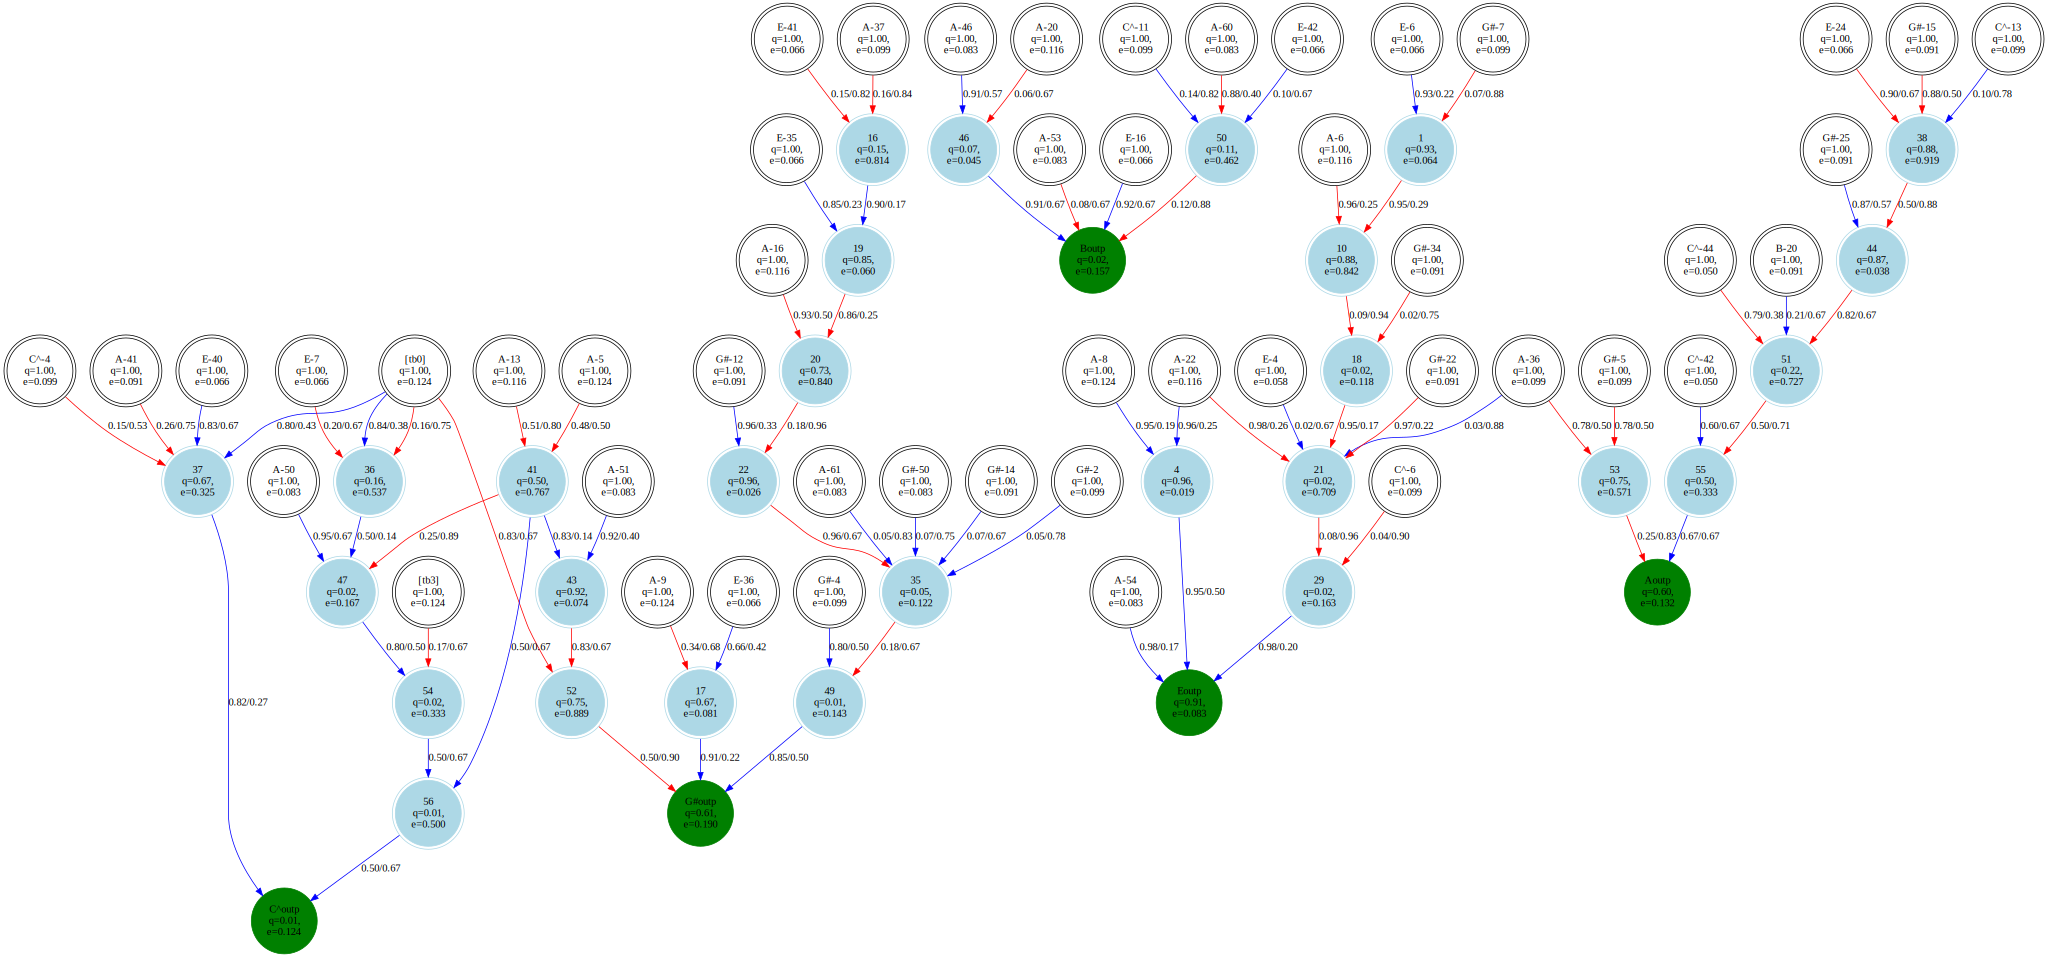

In [357]:
player.play_note.draw()

In [358]:
#player.play_note.draw().render("Бинарный слон запомнил (с FI) кузнечика (54 скрытых нейрона)")

In [359]:
len(player.play_note.neurons[-5].inputs)

3

# Random Walk Suicide Elephant

Сидя в нейроне, имеем следующие действия:
- выйти с неудачей. Вероятность: 1 - edge_opposite_quality, где edge - тот, по которому пришли. В аутпуте 0
- построить связь. Вероятность: 1 / errors
и для связей, по которой пришёл неправильный сигнал:
- если по этой связи ещё не было перехода, перейти туда. Вероятность 1 - input_signal_quality
- стаб. Вероятность edge.opposite_quality
- удалить связь. Вероятность 1 - edge.quality

Сэмплируем весь набор возможных "проблем", оставляем только те, которые 1 (если все 0, то оставляем все). Выбираем наиболее вероятную. Совершаем соответствующую процедуру. Делаем всё аккуратно, следим за значением сигналов в каждом нейроне...

## Результаты:
Отлично сходится. Слишком много нейронов (под конец свыше 1030). Слишком много связей.

# Правки:
- выбираем не наиболее вероятную, а случайную, пропорционально вероятностям. Нейронов стало ещё больше. Смерть на 69.
- выбираем случайную равновероятно. Похоже, очень много связей. Хм, да нет вроде, но работает дико медленно
- возврат и добавка связи теперь домножаются на EQ всех неверных связей. До 65 идёт хорошо, на 65 его вдруг дико схлопнуло

In [360]:
player = Player()

In [361]:
def stubs_input(F):
    return np.array([len(N.inputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()
def stubs_output(F):
    return np.array([len(N.outputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()

In [362]:
limit = 8
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while limit <= 128:#len(kuznechik.notes):
    #player.play_note.forget_info()
    
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons))
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
        stubs_outputs.append(stubs_output(player.play_note))
        stubs_inputs.append(stubs_input(player.play_note))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  853
0 
limit:  9  neurons_at_start:  853
1 0 
limit:  10  neurons_at_start:  853
0 
limit:  11  neurons_at_start:  853
1 0 
limit:  12  neurons_at_start:  853
0 
limit:  13  neurons_at_start:  853
1 0 
limit:  14  neurons_at_start:  854
0 
limit:  15  neurons_at_start:  854
1 2 2 0 
limit:  16  neurons_at_start:  856
0 
limit:  17  neurons_at_start:  856
1 1 4 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


2 6 3 3 4 4 4 6 3 2 1 0 
limit:  18  neurons_at_start:  860
0 
limit:  19  neurons_at_start:  860
1 3 1 0 
limit:  20  neurons_at_start:  862
0 
limit:  21  neurons_at_start:  862
2 4 5 6 4 7 4 6 5 7 8 3 7 3 7 5 2 3 3 3 3 0 
limit:  22  neurons_at_start:  863
0 
limit:  23  neurons_at_start:  863
2 7 10 6 2 1 0 
limit:  24  neurons_at_start:  858
0 
limit:  25  neurons_at_start:  858
1 3 5 3 5 2 5 4 4 6 2 4 0 
limit:  26  neurons_at_start:  860
0 
limit:  27  neurons_at_start:  860
2 3 3 2 10 5 4 1 0 
limit:  28  neurons_at_start:  863
0 
limit:  29  neurons_at_start:  863
2 6 13 9 4 11 10 15 9 8 6 4 7 4 5 4 5 4 2 4 2 4 2 7 9 12 5 12 8 11 6 3 9 7 7 10 5 5 5 8 11 11 11 8 7 5 5 8 7 7 13 4 7 6 4 3 7 7 4 7 7 5 7 5 1 0 
limit:  30  neurons_at_start:  865
0 
limit:  31  neurons_at_start:  865
1 0 
limit:  32  neurons_at_start:  866
0 
limit:  33  neurons_at_start:  866
0 
limit:  34  neurons_at_start:  866
0 
limit:  35  neurons_at_start:  866
1 3 2 1 0 
limit:  36  neurons_at_start:  867
0 

KeyboardInterrupt: 

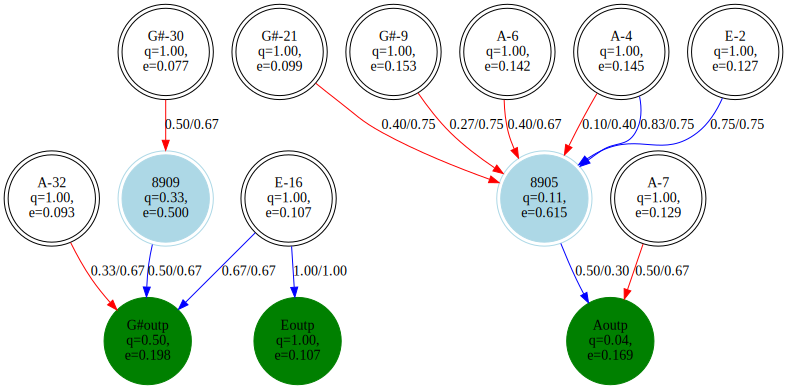

In [363]:
player.play_note.draw()

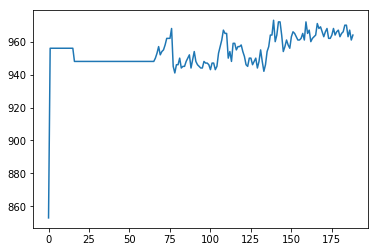

In [349]:
plt.plot(neurons)  # график количества нейронов в эпоху

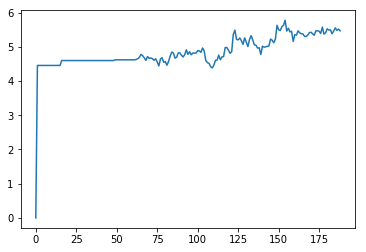

In [350]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

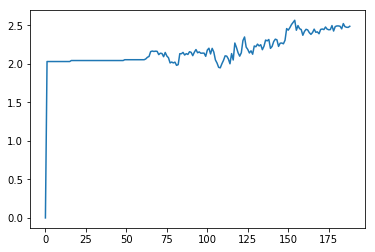

In [351]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

# Базовый вариант

In [263]:
player = Player()

In [264]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]
while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    stubs_outputs.append(stubs_output(player.play_note))
    stubs_inputs.append(stubs_input(player.play_note))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

102 78 106 89 79 113 105 92 104 83 101 97 104 101 94 86 86 92 97 97 94 113 114 104 79 97 97 96 88 70 81 101 92 88 91 80 83 90 97 91 95 91 114 110 107 86 101 110 111 81 89 97 96 86 105 94 90 101 90 99 105 87 104 109 75 101 95 98 91 85 90 96 95 95 94 87 103 104 77 86 101 92 90 81 83 76 87 91 90 105 94 100 84 95 106 83 73 98 86 92 91 92 94 95 85 95 90 75 109 77 90 98 105 95 77 88 86 94 100 88 105 88 88 89 74 77 66 103 92 86 87 102 90 71 94 85 73 83 85 75 89 92 94 86 74 86 94 98 96 106 98 70 72 93 90 86 73 108 102 99 75 93 83 84 89 93 84 86 88 104 88 69 71 87 70 88 86 89 92 79 94 69 100 81 75 71 81 80 70 79 89 79 73 80 77 77 72 70 78 79 88 94 85 81 77 77 77 77 63 63 71 50 68 73 63 81 73 116 94 77 73 81 78 86 99 

KeyboardInterrupt: 

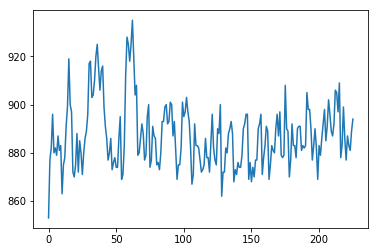

In [265]:
plt.plot(neurons)  # график количества нейронов в эпоху

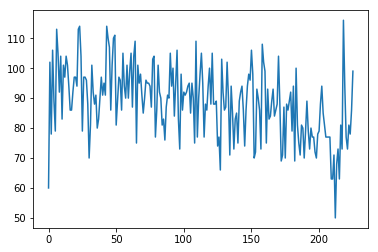

In [266]:
plt.plot(errors)  # график количества ошибок в эпоху

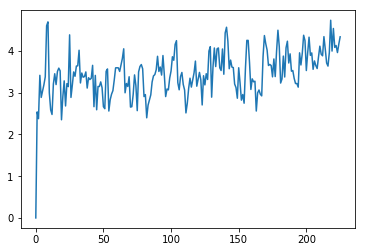

In [267]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

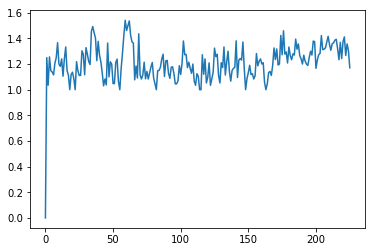

In [268]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

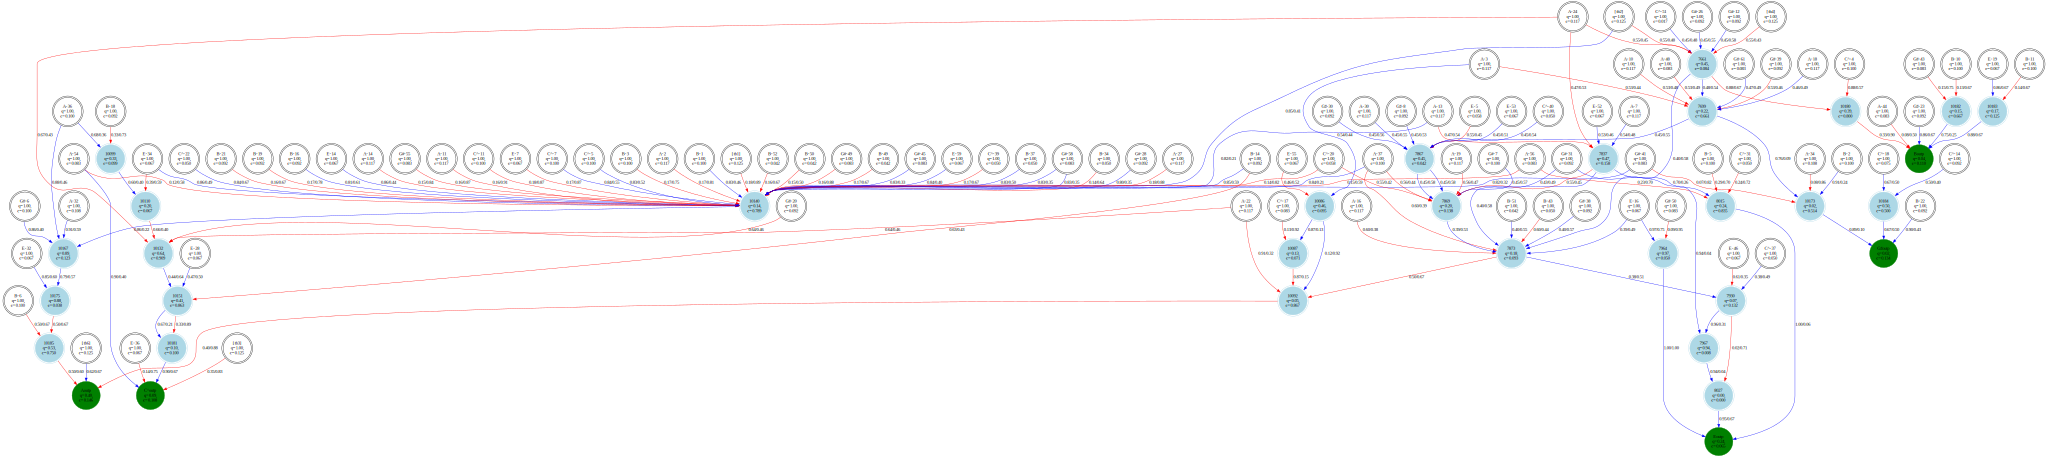

In [269]:
player.play_note.draw()

In [137]:
#player.play_note.draw().render('Бинарный слон') 

'Бинарный слон.png'

In [357]:
len(player.play_note.neurons)

947

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [138]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [139]:
simple_song = Song([12, -1, 11, -1, 9, -1, 8, -1])
result = player.improvise(simple_song)
result.play()

In [140]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [141]:
result.play()

## МНОГО ПЕСЕН

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [368]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [369]:
Songs = []
for i in range(1, 10):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

In [370]:
player = Player()

In [371]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])
neurons = []

In [372]:
while prev_errors.sum() > 10:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        neurons.append(len(player.play_note.neurons))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

99 111 91 75 73 79 101 121 59 107 74 71 146 99 174 98 70 76 69 101 97 80 111 
sum =  2182
128 116 57 115 82 76 90 89 73 58 71 53 67 66 85 168 82 63 53 70 77 56 67 
sum =  1862
78 66 42 55 52 64 69 79 36 58 58 47 54 44 73 57 56 60 45 62 60 37 64 
sum =  1316
71 56 37 39 54 53 62 73 35 61 61 54 82 50 78 59 71 72 50 89 68 46 87 
sum =  1408
62 73 49 58 60 68 65 100 55 79 67 41 69 52 69 62 67 70 52 77 67 55 82 
sum =  1499
78 58 40 53 50 54 67 74 39 67 94 66 63 58 72 84 74 67 72 99 84 52 80 
sum =  1545
87 60 48 48 65 75 88 88 55 67 92 78 71 72 87 95 89 77 47 103 74 57 73 
sum =  1696
95 58 51 44 64 69 82 67 44 62 81 67 55 56 75 73 58 52 52 61 62 66 75 
sum =  1469
75 68 35 54 56 55 70 77 40 55 73 102 70 50 72 62 73 70 45 64 53 43 73 
sum =  1435
75 59 50 50 55 54 59 69 40 48 58 64 59 51 67 59 59 57 58 75 98 59 73 
sum =  1396
92 63 71 66 61 69 73 69 63 52 63 68 49 53 59 67 57 51 49 68 63 50 66 
sum =  1442
69 69 36 44 56 48 63 71 43 46 58 50 46 42 63 48 53 64 49 61 63 40 68 
sum =  1250
7

KeyboardInterrupt: 

In [373]:
len(player.play_note.neurons)

1134

In [196]:
simple_song = Song('../basic midi/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [143]:
result.save_file("181. Binary Elephant NN learned kuznechik (94 hidden neurons)")

In [144]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [145]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()